In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
tracks = json.load(open("../data/groundtruth_tracks.json"))

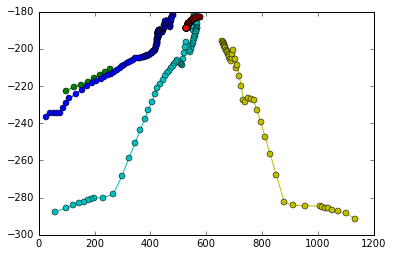

In [3]:
def displayTracks(tracks, k):
    for i in np.random.choice(len(tracks.items()), k):
        track = np.array(tracks.items()[i][1])
        plt.plot(track[0,0], -track[0,1], marker="x")
        plt.plot(track[:,0], -track[:,1], marker="o")
displayTracks(tracks, 5)

In [4]:
import pandas
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using Theano backend.


In [5]:
np.random.seed(7)

In [6]:
def buildLookbackDataset(tracks, lookback=3):
    lookback +=1
    dataset = []
    for key, track in tracks.items():
        for i, pos in enumerate(track):
            if i < lookback:
                continue
            dataset.append(np.array(track[i-lookback:i]).ravel())
    return dataset
                
dataset = buildLookbackDataset(tracks) 
# each row in the dataset is the x1, x2, y1, y2 
# where x1, x2 are the coordinate of previous position and y1,y2 are 
# coordinates of the next position or the location that should be predicted

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [8]:
# Split into test and train
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

(16751, 8251)


In [9]:
xtrain = np.matrix(train[:,0:6])
ytrain = np.matrix(train[:,6:])
xtest = np.matrix(test[:,0:6])
ytest = np.matrix(test[:,6:])

In [10]:
# reshape input to be [samples, time steps, features]
xtrain = np.reshape(np.array(xtrain), (xtrain.shape[0], 3, 2))
xtest = np.reshape(np.array(xtest), (xtest.shape[0], 3, 2))

In [11]:
xtrain[0].shape


(3, 2)

In [12]:
model = Sequential()
model.add(LSTM(4, input_shape=(3,2)))
model.add(Dense(2))
model.compile(loss='mean_squared_error', optimizer='adam')
model.load_weights('window3_weights.h5')

In [13]:
trainPredict = model.predict(xtrain)
testPredict = model.predict(xtest)
# invert predictions
#trainPredict = scaler.inverse_transform(np.concatenate((xtrain.reshape(xtrain.shape[0], xtrain.shape[2]),trainPredict), axis=1))[:,2:]
#trainY = scaler.inverse_transform([trainY])
#testPredict = scaler.inverse_transform(testPredict)
#testY = scaler.inverse_transform([testY])
# calculate root mean squared error

trainScore = math.sqrt(mean_squared_error(ytrain, trainPredict))
print('Train Score: %.7f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(ytest, testPredict))
print('Test Score: %.7f RMSE' % (testScore))

Train Score: 0.0081637 RMSE
Test Score: 0.0074623 RMSE


In [14]:
scaledPredictTrain = scaler.inverse_transform(np.concatenate((ytrain,trainPredict,ytrain,trainPredict), axis=1))
scaledPredictTest = scaler.inverse_transform(np.concatenate((ytest,testPredict,ytest,testPredict), axis=1))

trainScore = math.sqrt(mean_squared_error(scaledPredictTrain[:,0:2], scaledPredictTrain[:,2:4]))
print('Train Score: %.7f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(scaledPredictTest[:,0:2], scaledPredictTest[:,2:4]))
print('Test Score: %.7f RMSE' % (testScore))

print ytrain.shape

Train Score: 5.0506726 RMSE
Test Score: 4.9097064 RMSE
(16751, 2)


In [15]:
#print model.predict(np.array(tracks.items()[0][1][0]).reshape(1,1,2))
print tracks.items()[0][1][0]
print tracks.items()[0][1][1]

[777.654416, 165.681078]
[781.156791, 165.186175]


In [16]:
print np.array(tracks.items()[0][1][0]+tracks.items()[0][1][1]+tracks.items()[0][1][2]\
               +tracks.items()[0][1][3]).reshape(1,-1)
orig_scale=np.array(tracks.items()[0][1][0]+tracks.items()[0][1][1]+tracks.items()[0][1][2]\
               +tracks.items()[0][1][3]).reshape(1,-1)
l = scaler.transform(orig_scale)
print l
#x = l[0:2].reshape(1,1,2)
#y = l[2:]

[[ 777.654416   165.681078   781.156791   165.186175   784.809185
   164.670002   788.6214485  164.131158 ]]
[[ 0.62446123  0.09930999  0.62646688  0.09784558  0.62939047  0.09337126
   0.63313688  0.09231694]]


In [17]:
# Note this will predict the new point one frame ahead and build a track by 
# using measurements from the previous measurement.
# The first prediction is exactly the first measurement
# The last prediction is emitted because we know that the object is gone
# but currently the model has no method for predicting the death of an object
def rebuildTracks(tracks, model):
    predTracks = {}
    for track in tracks.items():
        predTracks[track[0]] = []
        t = predTracks[track[0]]
        for i, pos in enumerate(track[1]):
            if i < 3:
                t.append(pos)
            else:
                # scale and resize
                p1 = track[1][i-3]
                p2 = track[1][i-2]
                p3 = track[1][i-1]
                p = scaler.transform(np.array(p1+p2+p3+p3).reshape(1,-1))[0][0:6].reshape(1,3,2)
                # predict
                pred = model.predict(p).reshape(1,2).tolist()
                pred = scaler.inverse_transform(np.array(pred[0]+pred[0]+pred[0]+pred[0])\
                                                .reshape(1,-1))[0][0:2]
                t.append(pred)
    return predTracks

In [18]:
predictedTracks = rebuildTracks(tracks,model)

In [19]:
def displayPredictedTracks(tracks,predictedTracks, k):
    for i in np.random.choice(len(tracks.items()), k):
        if i / float(len(tracks.items())) < .67:
            print "Training"
        else:
            print "Testing"
        print "%d of %d"% (i, len(tracks.items()))
        key = tracks.items()[i][0]
        track = np.array(tracks.items()[i][1])
        t2 = np.array(predictedTracks[key])
        plt.plot(track[0,0], -track[0,1], marker="x")
        plt.plot(track[:,0], -track[:,1], marker="o", color='b')
        plt.plot(t2[:,0], -t2[:,1], marker="s", color='r')


Training
35 of 579


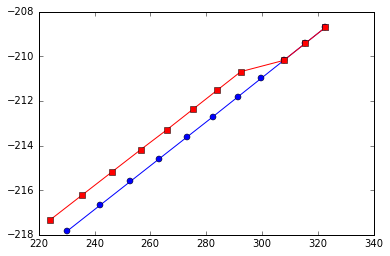

In [20]:
displayPredictedTracks(tracks,predictedTracks, 1)

In [21]:
mu_x = 28.0064938099
mu_y = 2.72131484714
def mle_var(tracks, predTracks):
    variances = {}
    x = []
    y = []
    for (key, track) in tracks.items():
        variances[key] = []
        for j, point in enumerate(track):
            x = ((point[0] - predictedTracks[key][j][0])**2)
            y = ((point[1] - predictedTracks[key][j][1])**2)
            variances[key].append((x,y))
    return variances

In [22]:
vs = mle_var(tracks, predictedTracks)

In [28]:
vs.items()[0][1][:10]


[(0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (59.051519587015022, 0.0045470953619918706),
 (73.012647262738113, 0.059362259853789109),
 (59.896413525135259, 0.0029621162838878632),
 (59.605454237795769, 0.0038927958646996731),
 (59.055032905112633, 0.0039116030436672578),
 (58.518140584899662, 0.0032548736582463148),
 (61.559383026794514, 0.096281645442805333)]

In [62]:
def buildVarDataset(tracks, predTracks, variance, lookback=3):
    lookback += 1
    dataset = []
    for key, track in tracks.items():
        for i, pos in enumerate(track):
            if i < lookback:
                continue
            gt = np.array(track[i-lookback:i-1]).ravel()
            pred = np.array(predTracks[key][i])
            var = np.array(variance[key][i])
            row = np.concatenate((gt, pred, var))
            dataset.append(row)
    return dataset
                
dataset = buildVarDataset(tracks, predictedTracks, vs) 
dataset = np.array(dataset)
# each row in the dataset is the x1, x2, y1, y2 
# where x1, x2 are the coordinate of previous position and y1,y2 are 
# coordinates of the next position or the location that should be predicted



In [63]:
# np.set_printoptions(suppress=True)
# plt.hist(dataset[:,8].clip(0,100))
# plt.show()
# plt.hist(dataset[:,9].clip(0,5))
# plt.show()
dataset[:,8] = dataset[:,8].clip(0,100)
dataset[:,9] = dataset[:,9].clip(0,5)

In [64]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Split into test and train
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

xtrain = np.matrix(train[:,0:8])
ytrain = np.matrix(train[:,8:])
xtest = np.matrix(test[:,0:8])
ytest = np.matrix(test[:,8:])

# reshape input to be [samples, time steps, features]
xtrain = np.reshape(np.array(xtrain), (xtrain.shape[0], 4, 2))
xtest = np.reshape(np.array(xtest), (xtest.shape[0], 4, 2))

xtrain[0].shape

(16751, 8251)


(4, 2)

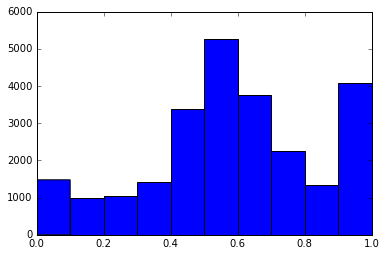

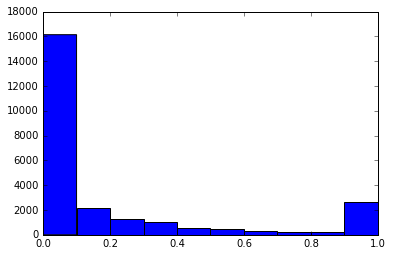

In [65]:
plt.hist(dataset[:,8])
plt.show()
plt.hist(dataset[:,9])
plt.show()

In [66]:
# Train LSTM based on distances
varmodel = Sequential()
varmodel.add(LSTM(32, input_shape=(4,2)))
varmodel.add(Dense(2))
adam = keras.optimizers.Adam(lr=0.01)
varmodel.compile(loss='mean_squared_error', optimizer='adam')
varmodel.fit(xtrain, ytrain, nb_epoch=10, batch_size=1, verbose=2)

Epoch 1/10
37s - loss: 0.0742
Epoch 2/10
28s - loss: 0.0667
Epoch 3/10
26s - loss: 0.0639
Epoch 4/10
25s - loss: 0.0624
Epoch 5/10
25s - loss: 0.0608
Epoch 6/10
29s - loss: 0.0595
Epoch 7/10
26s - loss: 0.0585
Epoch 8/10
26s - loss: 0.0574
Epoch 9/10
26s - loss: 0.0565
Epoch 10/10
32s - loss: 0.0557


In [67]:
trainPredict = varmodel.predict(xtrain)
testPredict = varmodel.predict(xtest)

scaledYTrain = scaler.inverse_transform(np.concatenate((xtrain.reshape((xtrain.shape[0],8)),ytrain), axis=1))
scaledYTest = scaler.inverse_transform(np.concatenate((xtest.reshape((xtest.shape[0],8)),ytest), axis=1))
scaledPredictTrain = scaler.inverse_transform(np.concatenate((xtrain.reshape((xtrain.shape[0],8)),trainPredict), axis=1))
scaledPredictTest = scaler.inverse_transform(np.concatenate((xtest.reshape((xtest.shape[0],8)),testPredict), axis=1))

trainScore = math.sqrt(mean_squared_error(scaledPredictTrain[:,8:], scaledYTrain[:,8:]))
print('Train Score: %.7f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(scaledPredictTest[:,8:], scaledYTest[:,8:]))
print('Test Score: %.7f RMSE' % (testScore))

Train Score: 15.1523971 RMSE
Test Score: 14.5813739 RMSE


In [68]:
trainScore = math.sqrt(mean_squared_error(scaledPredictTrain[:,8:9], scaledYTrain[:,8:9]))
print('Train Score: %.7f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(scaledPredictTest[:,8:9], scaledYTest[:,8:9]))
print('Test Score: %.7f RMSE' % (testScore))
trainScore = math.sqrt(mean_squared_error(scaledPredictTrain[:,9:], scaledYTrain[:,9:]))
print('Train Score: %.7f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(scaledPredictTest[:,9:], scaledYTest[:,9:]))
print('Test Score: %.7f RMSE' % (testScore))

Train Score: 21.3899492 RMSE
Test Score: 20.5845580 RMSE
Train Score: 1.2885446 RMSE
Test Score: 1.2283752 RMSE


In [71]:
print scaledYTest[140:160,8:]
print scaledPredictTest[140:160,8:]

[[ 100.            0.94636465]
 [ 100.            0.01139512]
 [ 100.            0.00795114]
 [ 100.            1.15653493]
 [ 100.            0.17626739]
 [ 100.            0.27425536]
 [ 100.            0.37187579]
 [ 100.            0.47825183]
 [ 100.            1.69755163]
 [ 100.            2.57565679]
 [ 100.            0.00313984]
 [  60.48581743    1.29040941]
 [ 100.            0.28708889]
 [  14.10614929    0.84378043]
 [ 100.            0.43423439]
 [ 100.            0.58399344]
 [  76.65928622    0.93659086]
 [ 100.            0.77034439]
 [  48.76786738    3.61040252]
 [ 100.            0.0109441 ]]
[[ 113.56660071    0.26428931]
 [ 123.44493769    0.32313526]
 [ 125.16544953    0.26117675]
 [ 125.78287018    0.27345128]
 [ 123.59163663    0.14663152]
 [ 126.64037833    0.14815658]
 [ 127.50385886    0.16424388]
 [ 124.88475935    0.1432031 ]
 [ 121.43288762    0.11714868]
 [ 116.27814702    0.03759176]
 [ 112.19176004    0.31122316]
 [  99.86205102    0.29414088]
 [  89.

In [72]:
#varmodel.save_weights('variance_32h_weights.h5')